In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Activation functions dictionary
act_dict = {
    'ReLU': nn.ReLU,
    'ELU': nn.ELU,
    'SiLU': nn.SiLU,
    # 'Mish': Mish(), # Uncomment if Mish is defined elsewhere
    'GELU': nn.GELU,
    'LeakyReLU': nn.LeakyReLU,
    'Tanh': nn.Tanh,
    'PReLU': nn.PReLU,
    'SELU': nn.SELU,
    'LogSigmoid': nn.LogSigmoid,
    'Sigmoid': nn.Sigmoid
}

# Base convolution block
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False, act='ReLU'):
        super().__init__()
        self.act = act_dict.get(act, nn.ReLU)()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size,
                             stride=stride, padding=padding, bias=bias)
        self.bn = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        return self.act(self.bn(self.conv(x)))

# Double convolution block (used in UNet variants)
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, act='ReLU'):
        super().__init__()
        self.act = act_dict.get(act, nn.ReLU)()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            self.act,
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            self.act,
        )

    def forward(self, x):
        return self.conv(x)

# Attention Modules
class ChannelAttention(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super().__init__()
        self.fc1 = nn.Conv2d(in_channels, in_channels // reduction, kernel_size=1)
        self.fc2 = nn.Conv2d(in_channels // reduction, in_channels, kernel_size=1)

    def forward(self, x):
        avg_pool = F.adaptive_avg_pool2d(x, 1)
        max_pool = F.adaptive_max_pool2d(x, 1)

        avg_out = self.fc2(F.relu(self.fc1(avg_pool)))
        max_out = self.fc2(F.relu(self.fc1(max_pool)))

        return torch.sigmoid(avg_out + max_out)

class SpatialAttention(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Conv2d(2, 1, kernel_size=7, padding=3)

    def forward(self, x):
        avg_pool = torch.mean(x, dim=1, keepdim=True)
        max_pool, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_pool, max_pool], dim=1)
        return torch.sigmoid(self.conv(x))

class CBAM(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super().__init__()
        self.channel_attention = ChannelAttention(in_channels, reduction)
        self.spatial_attention = SpatialAttention()

    def forward(self, x):
        x = x * self.channel_attention(x)
        x = x * self.spatial_attention(x)
        return x

class CoordinateAttention(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super().__init__()
        self.reduction = reduction
        self.fc_height = nn.Conv2d(in_channels, in_channels // reduction, kernel_size=1)
        self.fc_width = nn.Conv2d(in_channels, in_channels // reduction, kernel_size=1)
        self.attention_conv = nn.Conv2d(in_channels // reduction, in_channels, kernel_size=1)

    def forward(self, x):
        b, c, h, w = x.size()
        avg_height = torch.mean(x, dim=3, keepdim=True)
        avg_width = torch.mean(x, dim=2, keepdim=True)

        height_attention = self.fc_height(avg_height)
        height_attention = F.relu(height_attention)
        height_attention = self.attention_conv(height_attention)

        width_attention = self.fc_width(avg_width)
        width_attention = F.relu(width_attention)
        width_attention = self.attention_conv(width_attention)

        attention_map = torch.sigmoid(height_attention + width_attention)
        return x * attention_map

# Base UNet architecture
class BaseUNet(nn.Module):
    def __init__(self, in_channels, out_channels, features=[64, 128, 256, 512], act='ReLU',
                 attention_module=None, attention_params=None):
        super().__init__()
        self.downs = nn.ModuleList()
        self.ups = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.attention_module = attention_module
        self.attention_params = attention_params or {}

        # Down part
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature, act))
            if attention_module:
                self.downs.append(attention_module(feature, **self.attention_params))
            in_channels = feature

        # Bottleneck
        self.bottleneck = DoubleConv(features[-1], features[-1] * 2, act)

        # Up part
        for feature in reversed(features):
            self.ups.append(nn.ConvTranspose2d(feature * 2, feature, kernel_size=2, stride=2))
            self.ups.append(DoubleConv(feature * 2, feature, act))
            if attention_module:
                self.ups.append(attention_module(feature, **self.attention_params))

        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        # Encoder
        for i, down in enumerate(self.downs):
            x = down(x)
            if self.attention_module:
                if i % 2 == 0:  # Only store outputs from DoubleConv layers
                    skip_connections.append(x)
                    if i < len(self.downs) - 1:  # Don't pool after the last down layer
                        x = self.pool(x)
            else:
                skip_connections.append(x)
                x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        # Decoder
        step = 3 if self.attention_module else 2
        for i in range(0, len(self.ups), step):
            x = self.ups[i](x)  # Upsample
            skip_connection = skip_connections[i // step]

            if x.shape != skip_connection.shape:
                x = F.interpolate(x, size=skip_connection.shape[2:], mode='bilinear', align_corners=True)

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[i + 1](concat_skip)  # DoubleConv

            if self.attention_module and i + 2 < len(self.ups):
                x = self.ups[i + 2](x)  # Apply attention

        return self.final_conv(x)

# ResNet components for DeepLabV3+ and PSPNet
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1, downsample=None, act='ReLU'):
        super().__init__()
        self.act = act_dict.get(act, nn.ReLU)()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.act(out)
        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.act(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, layers, input_channels=3, act='ReLU'):
        super().__init__()
        self.act = act_dict.get(act, nn.ReLU)()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(input_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0], act=act)
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2, act=act)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2, act=act)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=1, act=act)

    def _make_layer(self, block, out_channels, blocks, stride=1, act='ReLU'):
        downsample = None
        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * block.expansion),
            )

        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample, act))
        self.in_channels = out_channels * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels, act=act))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.act(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        low_level_features = self.layer2(x)
        x = self.layer3(low_level_features)
        x = self.layer4(x)
        return x, low_level_features

# ASPP Module for DeepLabV3+
class ASPP(nn.Module):
    def __init__(self, in_channels, out_channels, atrous_rates, act='ReLU'):
        super().__init__()
        self.act = act_dict.get(act, nn.ReLU)()
        self.aspp1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, padding=0)
        self.aspp2 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=atrous_rates[0], dilation=atrous_rates[0])
        self.aspp3 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=atrous_rates[1], dilation=atrous_rates[1])
        self.aspp4 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=atrous_rates[2], dilation=atrous_rates[2])

        self.global_avg_pool = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(in_channels, out_channels, kernel_size=1, padding=0)
        )

        self.conv1x1 = nn.Conv2d(out_channels * 5, out_channels, kernel_size=1, padding=0)
        self.bn = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        size = x.size()[2:]

        aspp1 = self.aspp1(x)
        aspp2 = self.aspp2(x)
        aspp3 = self.aspp3(x)
        aspp4 = self.aspp4(x)

        global_avg = self.global_avg_pool(x)
        global_avg = F.interpolate(global_avg, size=size, mode='bilinear', align_corners=False)

        x = torch.cat([aspp1, aspp2, aspp3, aspp4, global_avg], dim=1)
        x = self.conv1x1(x)
        x = self.bn(x)
        return self.act(x)


# Pyramid Pooling Module for PSPNet
class PyramidPoolingModule(nn.Module):
    def __init__(self, in_channels, act='ReLU'):
        super().__init__()
        self.act = act_dict.get(act, nn.ReLU)()
        self.pools = nn.ModuleList([nn.AdaptiveAvgPool2d(output_size=(s, s)) for s in [1, 2, 3, 6]])
        self.convs = nn.ModuleList([
            nn.Conv2d(in_channels, in_channels // 4, kernel_size=1, bias=False) for _ in range(4)
        ])
        self.bns = nn.ModuleList([nn.BatchNorm2d(in_channels // 4) for _ in range(4)])

    def forward(self, x):
        h, w = x.size(2), x.size(3)
        features = [x]

        for pool, conv, bn in zip(self.pools, self.convs, self.bns):
            out = pool(x)
            out = conv(out)

            if out.size(2) > 1 and out.size(3) > 1:
                out = self.act(bn(out))
            else:
                out = self.act(out)

            out = F.interpolate(out, size=(h, w), mode='bilinear', align_corners=True)
            features.append(out)

        return torch.cat(features, dim=1)

# Model factory function
def create_model(model_type, in_channels, out_channels, features=[64, 128, 256, 512], act='ReLU'):
    if model_type == 'UNet':
        return BaseUNet(in_channels, out_channels, features, act)

    elif model_type == 'UNet_CBAM':
        return BaseUNet(in_channels, out_channels, features, act,
                        attention_module=CBAM, attention_params={'reduction': 16})

    elif model_type == 'UNet_CA':
        return BaseUNet(in_channels, out_channels, features, act,
                        attention_module=CoordinateAttention, attention_params={'reduction': 16})

    elif model_type == 'UNet_CBAM_SkipConnection':
        class UNet_CBAM_SkipConnection(nn.Module):
            def __init__(self, in_channels, out_channels, features, act):
                super().__init__()
                self.downs = nn.ModuleList()
                self.ups = nn.ModuleList()
                self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

                # Down part
                for feature in features:
                    self.downs.append(DoubleConv(in_channels, feature, act))
                    in_channels = feature

                # Bottleneck
                self.bottleneck = DoubleConv(features[-1], features[-1] * 2, act)

                # Up part
                for feature in reversed(features):
                    self.ups.append(nn.ConvTranspose2d(feature * 2, feature, kernel_size=2, stride=2))
                    self.ups.append(DoubleConv(feature * 2, feature, act))

                self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

            def forward(self, x):
                skip_connections = []

                # Encoder
                for down in self.downs:
                    x = down(x)
                    skip_connections.append(x)
                    x = self.pool(x)

                x = self.bottleneck(x)
                skip_connections = skip_connections[::-1]

                # Decoder
                for i in range(0, len(self.ups), 2):
                    x = self.ups[i](x)
                    skip_connection = skip_connections[i // 2]

                    # Apply CBAM to skip connection
                    cbam_connection = CBAM(skip_connection.shape[1])(skip_connection)

                    if x.shape != cbam_connection.shape:
                        x = F.interpolate(x, size=cbam_connection.shape[2:], mode='bilinear', align_corners=True)

                    concat_skip = torch.cat((cbam_connection, x), dim=1)
                    x = self.ups[i + 1](concat_skip)

                return self.final_conv(x)

        return UNet_CBAM_SkipConnection(in_channels, out_channels, features, act)

    elif model_type == 'DeepLabV3Plus':
        class DeepLabV3Plus(nn.Module):
            def __init__(self, in_channels, out_channels, act='ReLU'):
                super().__init__()
                self.act = act_dict.get(act, nn.ReLU)()
                self.backbone = ResNet(BasicBlock, [3, 4, 6, 3], input_channels=in_channels, act=act)
                self.aspp = ASPP(512 * BasicBlock.expansion, 256, atrous_rates=[6, 12, 18], act=act)

                self.low_level_project = nn.Sequential(
                    nn.Conv2d(128, 48, kernel_size=1, stride=1),
                    nn.BatchNorm2d(48),
                    self.act
                )

                self.decoder = nn.Sequential(
                    nn.Conv2d(304, 256, kernel_size=3, padding=1),
                    nn.BatchNorm2d(256),
                    self.act,
                    nn.Conv2d(256, 256, kernel_size=3, padding=1),
                    nn.BatchNorm2d(256),
                    self.act,
                    nn.ConvTranspose2d(256, out_channels, kernel_size=2, stride=2)
                )

            def forward(self, x):
                _, _, h, w = x.size()
                h_pad = (h + 3) // 4 * 4
                w_pad = (w + 3) // 4 * 4

                padding = (0, w_pad - w, 0, h_pad - h)
                x = F.pad(x, padding, mode='constant', value=0)

                input_size = (h, w)

                x, low_level_feat = self.backbone(x)
                x = self.aspp(x)

                low_level_feat = self.low_level_project(low_level_feat)
                x = F.interpolate(x, size=low_level_feat.size()[2:], mode='bilinear', align_corners=False)
                x = torch.cat([x, low_level_feat], dim=1)
                x = self.decoder(x)

                return F.interpolate(x, size=input_size, mode='bilinear', align_corners=False)

        return DeepLabV3Plus(in_channels, out_channels, act)

    elif model_type == 'HRNet':
        class HRNet(nn.Module):
            def __init__(self, in_channels, out_channels, act='ReLU'):
                super().__init__()
                self.act = act_dict.get(act, nn.ReLU)()

                self.stem = nn.Sequential(
                    nn.Conv2d(in_channels, 64, kernel_size=3, stride=1, padding=1, bias=False),
                    nn.BatchNorm2d(64),
                    self.act,
                    nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1, bias=False),
                    nn.BatchNorm2d(64),
                    self.act,
                )

                self.stage1 = self._make_stage(num_blocks=4, in_channels=64, out_channels=128)
                self.stage2 = self._make_stage(num_blocks=4, in_channels=128, out_channels=256)
                self.stage3 = self._make_stage(num_blocks=4, in_channels=256, out_channels=512)

                self.fuse = nn.Conv2d(512, out_channels, kernel_size=1)

            def _make_stage(self, num_blocks, in_channels, out_channels):
                layers = []
                layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False))
                layers.append(nn.BatchNorm2d(out_channels))
                layers.append(self.act)

                for _ in range(1, num_blocks):
                    layers.append(nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False))
                    layers.append(nn.BatchNorm2d(out_channels))
                    layers.append(self.act)

                return nn.Sequential(*layers)

            def forward(self, x):
                input_size = x.shape[2:]

                x = self.stem(x)
                x = self.stage1(x)
                x = self.stage2(x)
                x = self.stage3(x)

                x = self.fuse(x)
                x = F.interpolate(x, size=input_size, mode='bilinear', align_corners=True)

                return x

        return HRNet(in_channels, out_channels, act)

    elif model_type == 'PSPNet':

        class ResidualBlock(nn.Module):
            def __init__(self, in_channels, out_channels, stride=1, act='ReLU'):
                super().__init__()
                self.act = act_dict.get(act, nn.ReLU)()
                self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
                self.bn1 = nn.BatchNorm2d(out_channels)
                self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
                self.bn2 = nn.BatchNorm2d(out_channels)

                self.shortcut = nn.Sequential()
                if stride != 1 or in_channels != out_channels:
                    self.shortcut = nn.Sequential(
                        nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                        nn.BatchNorm2d(out_channels)
                    )

            def forward(self, x):
                out = self.act(self.bn1(self.conv1(x)))
                out = self.bn2(self.conv2(out))
                out += self.shortcut(x)
                out = self.act(out)
                return out

        class DynamicBackbone(nn.Module):
            def __init__(self, in_channels, min_size=8, act='ReLU'):
                super().__init__()
                self.actName = act
                self.act = act_dict.get(act, nn.ReLU)()

                self.initial_conv = nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
                self.bn = nn.BatchNorm2d(64)
                self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

                self.layer1 = ResidualBlock(64, 64, stride=1, act=act)
                self.layer2 = ResidualBlock(64, 128, stride=2, act=act)
                self.layer3 = ResidualBlock(128, 256, stride=2, act=act)
                self.layer4 = ResidualBlock(256, 512, stride=2, act=act)
                self.layer5 = ResidualBlock(512, 1024, stride=2, act=act)

            def forward(self, x):
                x = self.maxpool(self.act(self.bn(self.initial_conv(x))))
                x = self.layer1(x)
                x = self.layer2(x)
                x = self.layer3(x)
                x = self.layer4(x)
                x = self.layer5(x)
                return x, 1024

        class PSPNet(nn.Module):
            def __init__(self, in_channels, out_channels, act='ReLU'):
                super().__init__()
                self.act = act_dict.get(act, nn.ReLU)()
                self.backbone = DynamicBackbone(in_channels, act=act)
                self.ppm = PyramidPoolingModule(1024, act=act)

                self.final_conv1 = nn.Conv2d(2048, 512, kernel_size=3, padding=1, bias=False)
                self.final_bn1 = nn.BatchNorm2d(512)
                self.final_conv2 = nn.Conv2d(512, out_channels, kernel_size=1)
                self.dropout = nn.Dropout2d(p=0.1)

            def forward(self, x):
                input_size = x.size()[2:]

                features, _ = self.backbone(x)
                features = self.ppm(features)

                features = self.act(self.final_bn1(self.final_conv1(features)))
                features = self.dropout(features)
                features = self.final_conv2(features)

                out = F.interpolate(features, size=input_size, mode='bilinear', align_corners=True)
                return out

        return PSPNet(in_channels, out_channels, act)

    else:
        raise ValueError(f"Unknown model type: {model_type}")




Testing input with dimensions: [C=15, H=210, W=150]
  Testing UNet...
    Success! Output shape: torch.Size([1, 10, 210, 150])
  Testing UNet_CBAM...
    Success! Output shape: torch.Size([1, 10, 210, 150])
  Testing UNet_CA...
    Success! Output shape: torch.Size([1, 10, 210, 150])
  Testing UNet_CBAM_SkipConnection...
    Success! Output shape: torch.Size([1, 10, 210, 150])
  Testing DeepLabV3Plus...
    Success! Output shape: torch.Size([1, 10, 210, 150])
  Testing HRNet...
    Success! Output shape: torch.Size([1, 10, 210, 150])
  Testing PSPNet...
    Success! Output shape: torch.Size([1, 10, 210, 150])

Testing input with dimensions: [C=128, H=472, W=355]
  Testing UNet...
    Success! Output shape: torch.Size([1, 10, 472, 355])
  Testing UNet_CBAM...
    Success! Output shape: torch.Size([1, 10, 472, 355])
  Testing UNet_CA...
    Success! Output shape: torch.Size([1, 10, 472, 355])
  Testing UNet_CBAM_SkipConnection...
    Success! Output shape: torch.Size([1, 10, 472, 355])


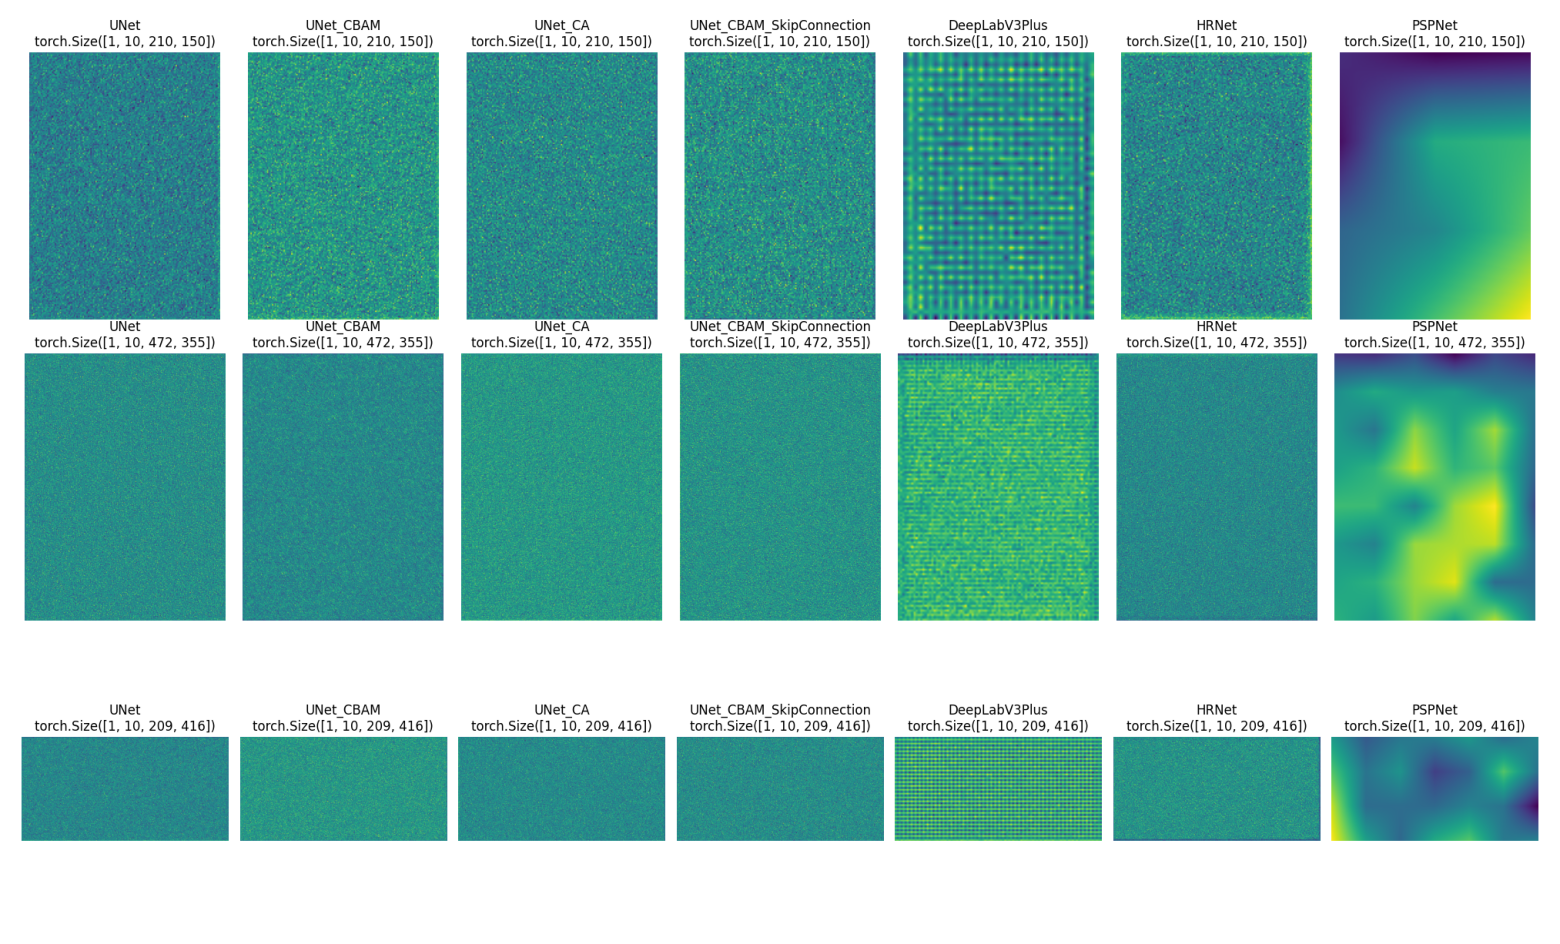

In [5]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# Test with the arbaterary input dimensions
def test_models():
    # Define the test input dimensions
    test_inputs = [
        (15, 210, 150),   # [C, H, W]
        (128, 472, 355),  # [C, H, W]
        (25, 209, 416)    # [C, H, W]
    ]

    # Define the models to test
    model_types = [
        'UNet',
        'UNet_CBAM',
        'UNet_CA',
        'UNet_CBAM_SkipConnection',
        'DeepLabV3Plus',
        'HRNet',
        'PSPNet'
    ]

    # Set output channels (classes) for all models
    out_channels = 10

    # Create a figure for visualization
    fig, axes = plt.subplots(len(test_inputs), len(model_types), figsize=(20, 12))

    # Test each model with each input dimension
    for i, (in_channels, height, width) in enumerate(test_inputs):
        print(f"\nTesting input with dimensions: [C={in_channels}, H={height}, W={width}]")

        # Create a random input tensor
        x = torch.randn(1, in_channels, height, width)

        for j, model_type in enumerate(model_types):
            print(f"  Testing {model_type}...")

            try:
                # Create the model
                model = create_model(model_type, in_channels, out_channels)

                # Set model to evaluation mode
                model.eval()

                # Forward pass
                with torch.no_grad():
                    output = model(x)

                # Print output shape
                print(f"    Success! Output shape: {output.shape}")

                # Visualize a slice of the output (first channel)
                if isinstance(output, tuple):
                    output = output[0]

                # Plot the output
                ax = axes[i, j]
                im = ax.imshow(output[0, 0].numpy(), cmap='viridis')
                ax.set_title(f"{model_type}\n{output.shape}")
                ax.axis('off')

            except Exception as e:
                print(f"    Failed: {str(e)}")

                # Show error in the plot
                ax = axes[i, j]
                ax.text(0.5, 0.5, f"Error: {str(e)}",
                        horizontalalignment='center',
                        verticalalignment='center',
                        transform=ax.transAxes,
                        wrap=True)
                ax.set_title(f"{model_type} - Failed")
                ax.axis('off')

    plt.tight_layout()
    plt.savefig('model_test_results.png')
    plt.close()

    return "All tests completed. Check visualization for verification."

# Run the tests
result = test_models()
print(result)

# Display the saved visualization
img = plt.imread('model_test_results.png')
plt.figure(figsize=(20, 12))
plt.imshow(img)
plt.axis('off')
plt.show()